In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.cuda.empty_cache()
class double_conv2d_bn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, strides=1, padding=1):
        super(double_conv2d_bn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=strides, padding=padding, bias=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=strides, padding=padding, bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

class deconv2d_bn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, strides=2):
        super(deconv2d_bn, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=strides, bias=True)
        # Example of adding padding to a convolutional layer

        self.bn1 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        return out

class Unet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Unet, self).__init__()
        self.layer1_conv = double_conv2d_bn(input_channels, 8)
        self.layer2_conv = double_conv2d_bn(8, 16)
        self.layer3_conv = double_conv2d_bn(16, 32)
        self.layer4_conv = double_conv2d_bn(32, 64)
        self.layer5_conv = double_conv2d_bn(64, 128)
        self.layer6_conv = double_conv2d_bn(128, 64)
        self.layer7_conv = double_conv2d_bn(64, 32)
        self.layer8_conv = double_conv2d_bn(32, 16)
        self.layer9_conv = double_conv2d_bn(16, 8)
        self.layer10_conv = nn.Conv2d(8, output_channels, kernel_size=3, stride=1, padding=1, bias=True)

        self.deconv1 = deconv2d_bn(128, 64)
        self.deconv2 = deconv2d_bn(64, 32)
        self.deconv3 = deconv2d_bn(32, 16)
        self.deconv4 = deconv2d_bn(16, 8)

        self.sigmoid = nn.Sigmoid()
        self.input_channels = input_channels  # Update input channels
        self.output_channels = output_channels

    def forward(self, x):
        conv1 = self.layer1_conv(x)

        pool1 = F.max_pool2d(conv1, 2)

        conv2 = self.layer2_conv(pool1)
        pool2 = F.max_pool2d(conv2, 2)

        conv3 = self.layer3_conv(pool2)
        pool3 = F.max_pool2d(conv3, 2)

        conv4 = self.layer4_conv(pool3)
       

        pool4 = F.max_pool2d(conv4, 2)

        conv5 = self.layer5_conv(pool4)

        convt1 = self.deconv1(conv5)
        convt1 = F.interpolate(convt1, size=(3, 3), mode='bilinear', align_corners=False)
   
        concat1 = torch.cat([convt1, conv4], dim=1)
        conv6 = self.layer6_conv(concat1)

        convt2 = self.deconv2(conv6)
        convt2 = F.interpolate(convt2, size=(7, 7), mode='bilinear', align_corners=False)
        concat2 = torch.cat([convt2, conv3], dim=1)

        conv7 = self.layer7_conv(concat2)

        convt3 = self.deconv3(conv7)
        concat3 = torch.cat([convt3, conv2], dim=1)
        conv8 = self.layer8_conv(concat3)

        convt4 = self.deconv4(conv8)
        concat4 = torch.cat([convt4, conv1], dim=1)
        conv9 = self.layer9_conv(concat4)
        outp = self.layer10_conv(conv9)
        outp = self.sigmoid(outp)

        return outp


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(100, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 784)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x



class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.neural_network = NeuralNetwork()
        self.unet = Unet(input_channels=1, output_channels=1)

    def forward(self, x):
        nn_output = self.neural_network(x)
        # Ensure nn_output has one channel
        nn_output = nn_output.unsqueeze(1)
        # Reshape nn_output to match the expected input shape of the U-Net
        # Inside CombinedModel's forward method
        nn_output = nn_output.view(nn_output.size(0), 1, 28, 28)

        unet_output = self.unet(nn_output)

        unet_output_flat = unet_output.view(-1, 784)

        return  unet_output_flat



# 创建合并后的模型
# Create an instance of CombinedModel
combined_model = CombinedModel()

# Move the model to the specified device
model = combined_model.to(device)

print(f"Before forward pass - GPU memory used: {torch.cuda.memory_allocated() / 1e9} GB")

Before forward pass - GPU memory used: 0.076132864 GB


In [10]:
import pickle
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 读取.pkl文件
with open('unbalance2-train-spikecount.pkl', 'rb') as file:
    input_data = pickle.load(file)

# 转换为张量
inputs = torch.tensor(input_data, dtype=torch.float32).to(device)
print(f"Before forward pass - GPU memory used: {torch.cuda.memory_allocated() / 1e9} GB")

with open('train-raw_image.pkl', 'rb') as file:
    goal = pickle.load(file)

with open('unbalance2-test-spikecount.pkl', 'rb') as file:
    test_data = pickle.load(file)
with open('test-raw_image.pkl', 'rb') as file:
    test_goal = pickle.load(file)
test_data = torch.tensor(test_data, dtype=torch.float32).to(device)

goal = torch.tensor(goal, dtype=torch.float32).to(device)
test_goal = torch.tensor(test_goal, dtype=torch.float32).to(device)
goal=goal
test_goal=test_goal


print(inputs.shape)
print(goal.shape)
print(test_data.shape)
print(test_goal.shape)


Before forward pass - GPU memory used: 0.080126464 GB
torch.Size([10000, 100])
torch.Size([10000, 784])
torch.Size([1000, 100])
torch.Size([1000, 784])


In [11]:
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import tempfile
import numpy as np
print(f"Before forward pass - GPU memory used: {torch.cuda.memory_allocated() / 1e9} GB")

Before forward pass - GPU memory used: 0.115069952 GB


In [12]:
torch.cuda.empty_cache()
print(f"Before forward pass - GPU memory used: {torch.cuda.memory_allocated() / 1e9} GB")

Before forward pass - GPU memory used: 0.115069952 GB


In [13]:
from torch.utils.data import DataLoader, TensorDataset
import gc
torch.cuda.empty_cache()
print(f"Before forward pass - GPU memory used: {torch.cuda.memory_allocated() / 1e9} GB")

loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)

goal = goal.view(-1, 784)

dataset = TensorDataset(inputs, goal)


# 定义DataLoader
dataloader = DataLoader(
    dataset=dataset, 
    batch_size=32,
    shuffle=True,
)  # 这样将保持图像和标签的对应关系
    
gc.collect()
torch.cuda.empty_cache()
print(f"Before forward pass - GPU memory used: {torch.cuda.memory_allocated() / 1e9} GB")

for epoch in range(500):
    for i, batch in enumerate(dataloader):
        inputs, goal = batch
        model_outputs = model(inputs)
        loss = loss_fn(model_outputs, goal)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    torch.cuda.empty_cache()
    gc.collect()
    print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))
model.eval()


Before forward pass - GPU memory used: 0.115069952 GB
Before forward pass - GPU memory used: 0.069430784 GB
Epoch: 0, Loss: 0.07793470472097397
Epoch: 1, Loss: 0.0384967103600502
Epoch: 2, Loss: 0.03205345198512077
Epoch: 3, Loss: 0.02437933161854744
Epoch: 4, Loss: 0.023710841313004494
Epoch: 5, Loss: 0.021176384761929512
Epoch: 6, Loss: 0.015625089406967163
Epoch: 7, Loss: 0.01764047145843506
Epoch: 8, Loss: 0.013443232513964176
Epoch: 9, Loss: 0.0160558819770813
Epoch: 10, Loss: 0.013076450675725937
Epoch: 11, Loss: 0.01506028976291418
Epoch: 12, Loss: 0.014367850497364998
Epoch: 13, Loss: 0.01449186634272337
Epoch: 14, Loss: 0.013572094030678272
Epoch: 15, Loss: 0.00994043331593275
Epoch: 16, Loss: 0.0120428167283535
Epoch: 17, Loss: 0.011545741930603981
Epoch: 18, Loss: 0.012594370171427727
Epoch: 19, Loss: 0.009750370867550373
Epoch: 20, Loss: 0.010480598546564579
Epoch: 21, Loss: 0.012863438576459885
Epoch: 22, Loss: 0.010725327767431736
Epoch: 23, Loss: 0.013889210298657417
Epo

CombinedModel(
  (neural_network): NeuralNetwork(
    (fc1): Linear(in_features=100, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=784, bias=True)
  )
  (unet): Unet(
    (layer1_conv): double_conv2d_bn(
      (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer2_conv): double_conv2d_bn(
      (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=T

In [14]:
testdataset = TensorDataset(test_data, test_goal)
testdataloader = DataLoader(
    dataset=testdataset, 
    batch_size=32,
    shuffle=True,
) 
criterion = torch.nn.MSELoss()

test_loss = 0.0
total_batches = 0
with torch.no_grad():  # Disable gradient computation during testing
    for i, batch in enumerate(testdataloader):
        test_data, test_goal = batch
        model_outputs = model(test_data)
        loss = criterion(model_outputs, test_goal)
        test_loss += loss.item()
        total_batches += 1
average_test_loss = test_loss / total_batches
print('Average Test Loss: {}'.format(average_test_loss))

Average Test Loss: 0.018553144327597693


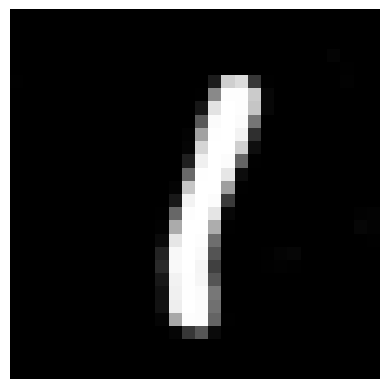

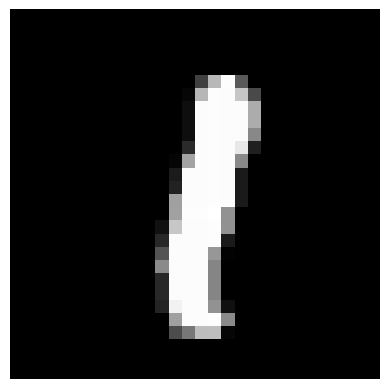

PSNR: 19.901050567626953, SSIM: 0.8771962871066183


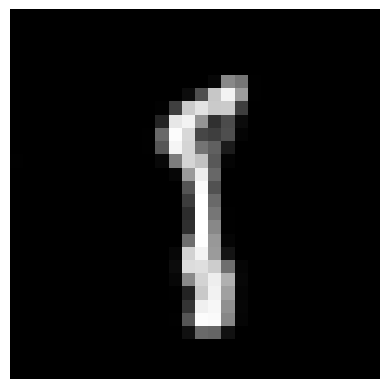

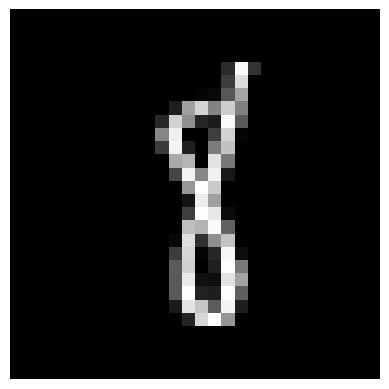

PSNR: 16.1214599609375, SSIM: 0.7452766185276422


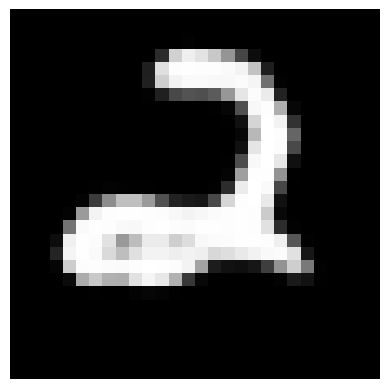

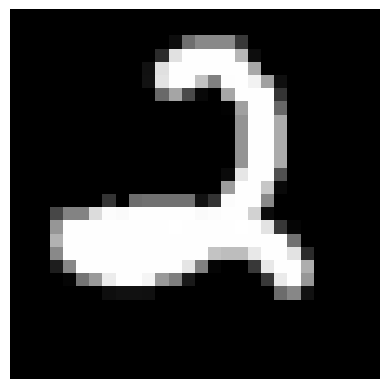

PSNR: 18.131765365600586, SSIM: 0.8393152821369042


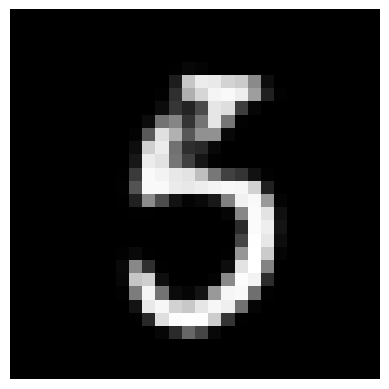

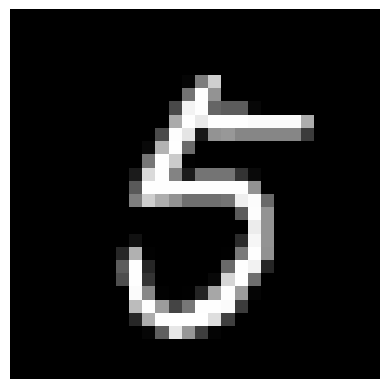

PSNR: 14.999612808227539, SSIM: 0.6654395434159041


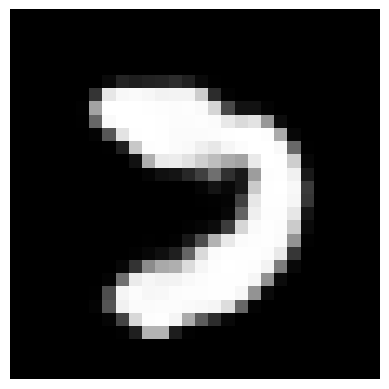

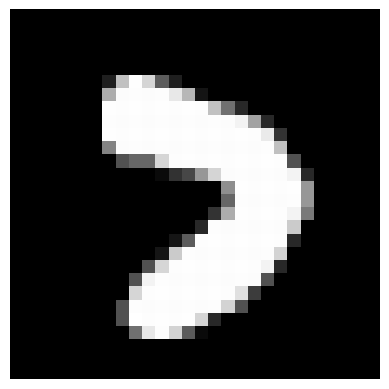

PSNR: 16.385730743408203, SSIM: 0.791342383050215


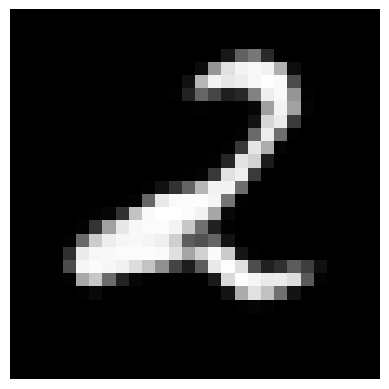

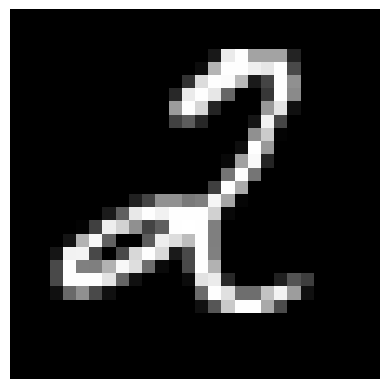

PSNR: 13.168478012084961, SSIM: 0.579546510185556


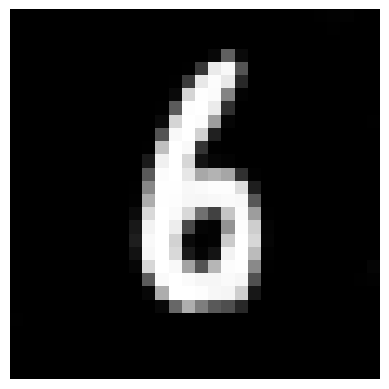

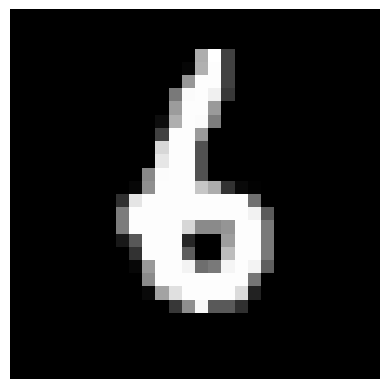

PSNR: 17.750614166259766, SSIM: 0.8194945395957826


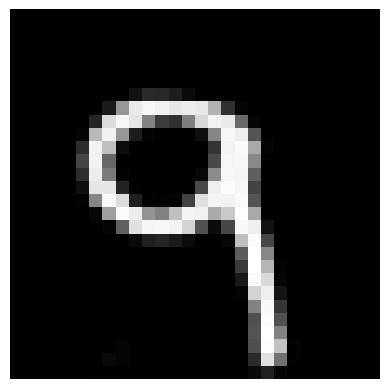

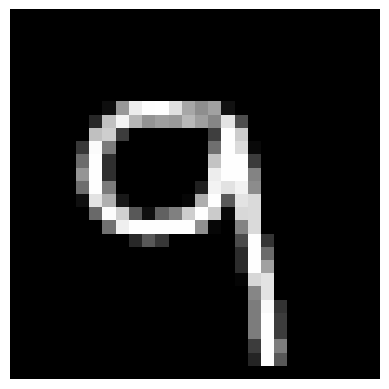

PSNR: 19.97364044189453, SSIM: 0.888215379250302


In [15]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim

with torch.no_grad():
    reconstructed_images = model_outputs[:10]
    for i, image in enumerate(reconstructed_images):
        image = image.view(28, 28).cpu()

        original_image = test_goal[i].view(28, 28).cpu()
        original_image_np = original_image.detach().cpu().numpy().squeeze()  # Convert to NumPy array
        image_np = image.detach().cpu().numpy().squeeze()  # Convert to NumPy array

        # Ensure the data type is float
        original_image_np = original_image_np.astype(float)
        image_np = image_np.astype(float)
        
        # 计算 PSNR
        mse = F.mse_loss(image, original_image)
        psnr = 20 * torch.log10(1 / torch.sqrt(mse))
        data_range = 1.0  # Adjust this if your images have a different valid range
        ssim_index, _ = compare_ssim(original_image_np, image_np, full=True, data_range=data_range)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.show()
        plt.imshow(original_image, cmap='gray')
        plt.axis('off')
        plt.show()
        print(f"PSNR: {psnr}, SSIM: {ssim_index}")
        

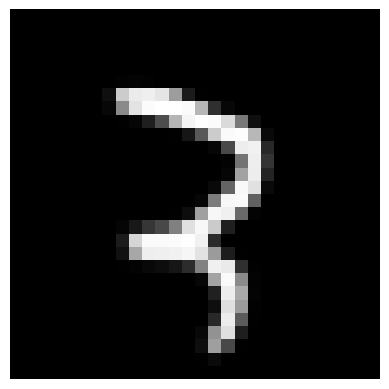

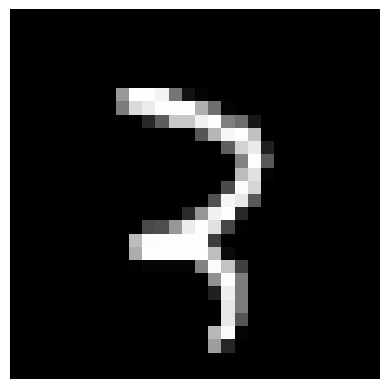

PSNR: 29.425281524658203, SSIM: 0.9732113333304734


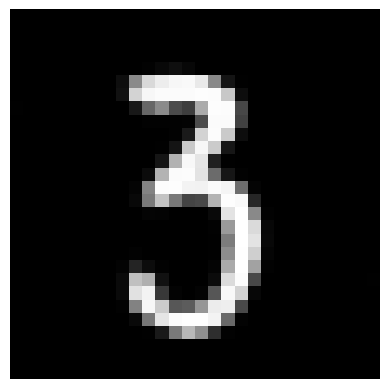

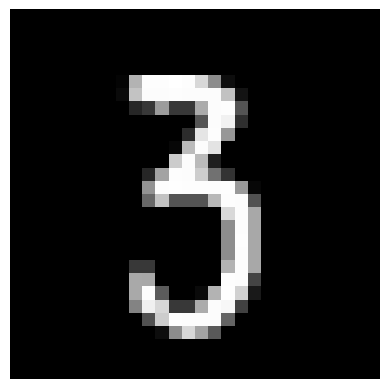

PSNR: 29.16437530517578, SSIM: 0.9842702553821459


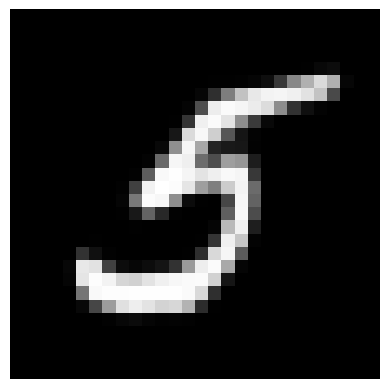

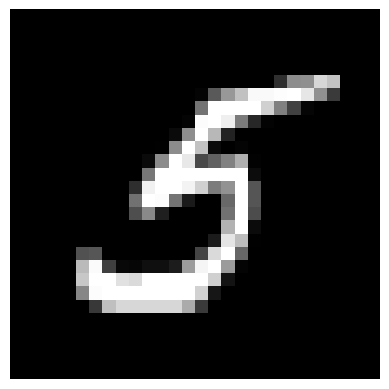

PSNR: 28.782470703125, SSIM: 0.9820594764271647


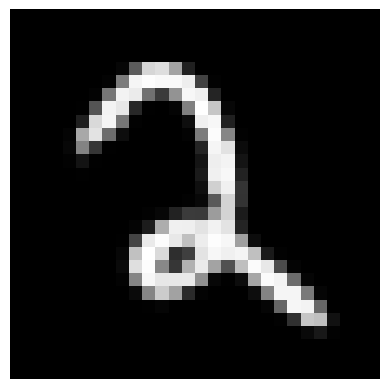

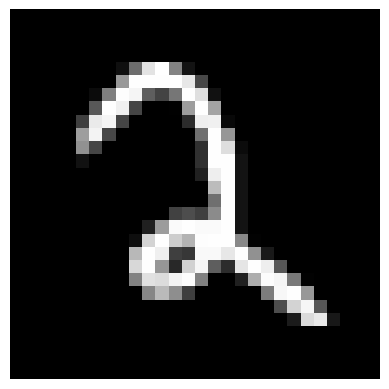

PSNR: 29.26251983642578, SSIM: 0.9843075791093988


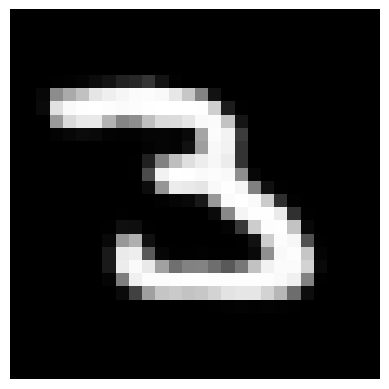

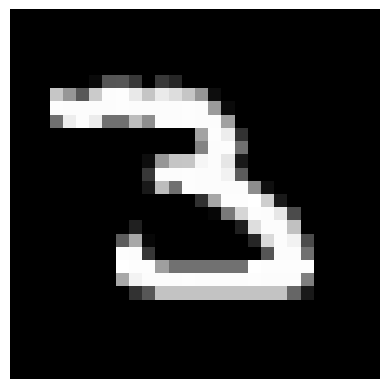

PSNR: 26.132457733154297, SSIM: 0.9717833053883329


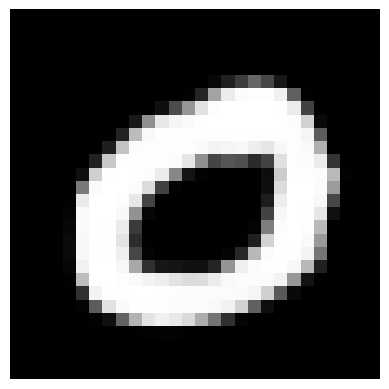

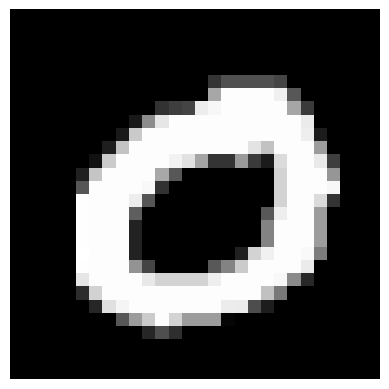

PSNR: 26.174297332763672, SSIM: 0.9854049736996916


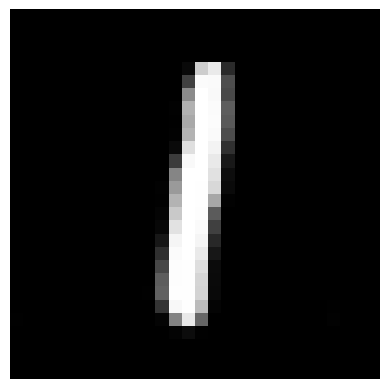

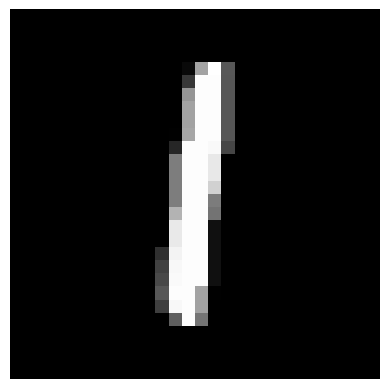

PSNR: 32.00653839111328, SSIM: 0.9879307134197253


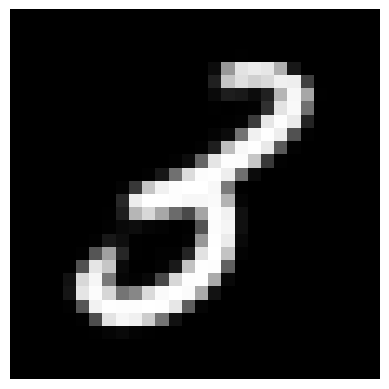

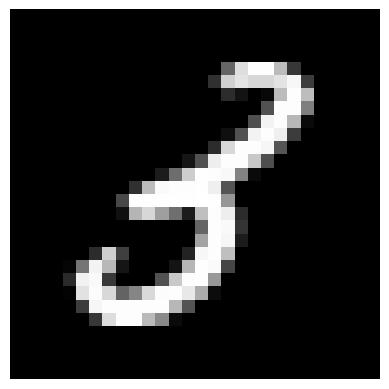

PSNR: 30.19415283203125, SSIM: 0.9859449456576969


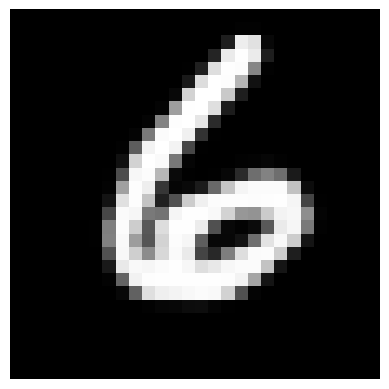

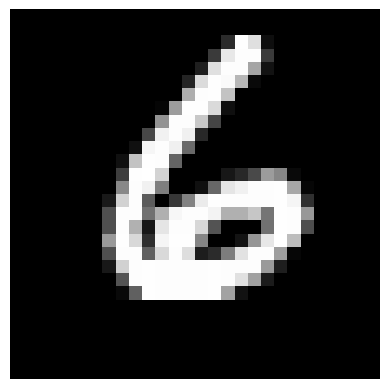

PSNR: 26.74983787536621, SSIM: 0.978971835560907


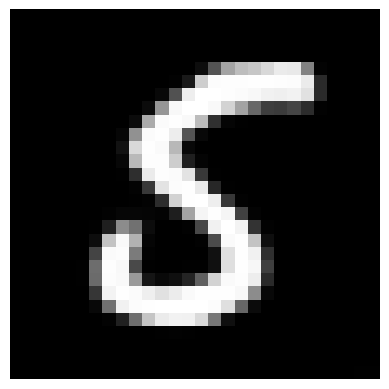

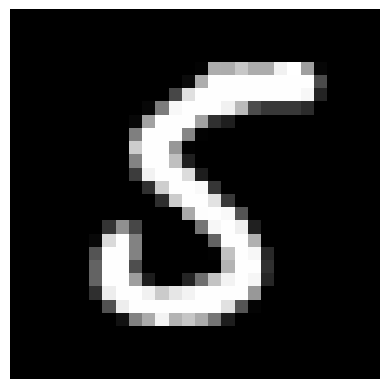

PSNR: 29.427854537963867, SSIM: 0.9885591123852414


In [16]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim

with torch.no_grad():
    reconstructed_images = model(inputs[:10])
    for i, image in enumerate(reconstructed_images):
        image = image.view(28, 28).cpu()

        original_image = goal[i].view(28, 28).cpu()
        original_image_np = original_image.detach().cpu().numpy().squeeze()  # Convert to NumPy array
        image_np = image.detach().cpu().numpy().squeeze()  # Convert to NumPy array

        # Ensure the data type is float
        original_image_np = original_image_np.astype(float)
        image_np = image_np.astype(float)
        
        # 计算 PSNR
        mse = F.mse_loss(image, original_image)
        psnr = 20 * torch.log10(1 / torch.sqrt(mse))
        data_range = 1.0  # Adjust this if your images have a different valid range
        ssim_index, _ = compare_ssim(original_image_np, image_np, full=True, data_range=data_range)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.show()
        plt.imshow(original_image, cmap='gray')
        plt.axis('off')
        plt.show()
        print(f"PSNR: {psnr}, SSIM: {ssim_index}")
        

In [17]:
import pickle
import os

# Assuming 'model' is an instance of your PyTorch model
# ...

# Specify the path to the desktop and the filename
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
file_path = os.path.join(desktop_path, 'unbalancedunet_model.pth')

# Save the model state dictionary
model_state_dict = model.state_dict()
torch.save(model_state_dict, file_path)